In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
ROWS    = 6                        # Number of rows in the board
COLS    = 7                        # Number of columns in the board
INPUT   = 2*(ROWS*COLS) + 1        # Number of neurons in the input layer
POPU    = 24                       # Population size ( for the genetic algo )
EPOCHS  = 30                       # Number of generations ( for the genetic algo )
LIFE    = 10                       # Number of ...( for the genetic algo )
MUTAT   = 1                        # Average mutation strenght ( for the genetic algo )
HIDDEN  = 0                        # Number of hidden layers
LAYERS  = [INPUT, COLS]            # Number of neurons in each layer
COLORS  = {'Red':1, 'Yellow':2}
PLAYERS = ['Draw', 'Red', 'Yellow']

In [78]:
# Board functions

def NewTable():
    return np.zeros(shape=(ROWS,COLS))

def DropIn(table, j, color):
     
    ok = ( not IsColFull(table,j ) )
    for i in range(1,ROWS+1):
        if table[ROWS-i][j]==0:
            table[ROWS-i][j] = color
            break

    return table, ok

def IsFull(board):
    return ( len(board[board==0]) == 0 )

def IsColFull(board, j):
    return ( len(board[:,j][board[:,j]==0]) == 0 )

def DrawBoard(table):
    for i in range(0,ROWS):
        for j in range(0,COLS):
            pedina = table[ROWS-i-1][j]
            if   pedina == 1: color='red'
            elif pedina == 2: color='yellow'
            else : color='white'
            circle = plt.Circle((j,i), 0.4, fc=color)
            plt.gca().add_patch(circle)
    plt.axis('scaled')
    

# Game Evaluation functions ( who won? )

def CheckRow(i, table):
    row = table[i]
    for j in range(0,COLS-4+1):
        x = np.prod(row[j:j+4])
        if x==1**4 :
            return 1     
        elif x==2**4 :
            return 2
    return 0

def CheckColumn(j, table):
    col = table[:,j]
    for i in range(0,ROWS-4+1):
        x = np.prod(col[i:i+4])
        if x==1**4 :
            return 1
        elif x==2**4 :
            return 2
    return 0

def CheckDiagonal(i, j, table, anti=False):
    
    direction = 1 - 2*int(anti)
    diag = np.zeros(4)
    for k in range(0,4):
        diag[k] = table[ i+k, j + direction * k ]
    x = np.prod(diag)

    if x==1**4 :
        return 1
    elif x==2**4 :
        return 2
    else :
        return 0
    
def Winner(table):
    for i in range(0,ROWS):
        x = CheckRow(i, table)
        if x: return x
        
        for j in range(0,COLS):
            x = CheckColumn(j, table)
            if x: return x
            
            if i < ROWS-4+1:
                if j < COLS-4+1:
                    x = CheckDiagonal(i,j, table)
                    if x: return x

                if j >= COLS-4:
                    x = CheckDiagonal(i,j, table, anti=True)
                    if x: return x
    return x

def AnnounceWinner(board):
    x = Winner(board)
    if x > 0: print('{0} won!'.format(PLAYERS[x]))

In [317]:
# Neural Net functions

def Sigmoid(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

def HotVector(n):
    v = np.zeros(COLS)
    v[n] = 1
    return v

def RandomTrain(X,Y,N):
    idx = np.random.choice(range(0, len(X)), N)
    return X[idx], Y[idx]

def Input(board):
    X1  = board.reshape(COLS*ROWS).copy()
    X1[X1==2] = 0
    X2  = board.reshape(COLS*ROWS).copy()
    X2[X2==1] = 0   
    X2[X2==2] = 1  
    X  = np.append(1, X1)
    X  = np.append(X, X2)
    return X

def ForwardProp(X0, w):
    X1  = Sigmoid( np.dot( X0, w.T ) )
    #X1[:,0] = 1 # Bias unit
    #X2  = Sigmoid( np.dot( X1, w[1].T ) )
    return X1

def Response(table, w, full=False):
    
    X0  = Input(table)
    Y   = Sigmoid(ForwardProp(Input(table), w))
    for i in range(0, COLS):
        if ( IsColFull(table,i) ): Y[i] = 0
    
    if full : return Y
    return np.argmax(Y)

def MakeMove(table, w1, p):
    table, ok = DropIn(table, Response(table, w1), p)
    return table


# Genetic Algo functions

def RandomWeights():
    
    we = []
    for h in range(0, HIDDEN+1):
        we.append( np.random.uniform(low=-1, high=1, size=(LAYERS[h+1], LAYERS[h])) )
    return we
        
def Mutate(w1):
    new = []
    for h in range(0, HIDDEN+1):
        new.append( w1[h] + MUTAT * np.random.normal(size=(LAYERS[h+1], LAYERS[h])) )
    return new

def Reward(winner,number_of_moves):
    if   winner==0: return 0
    elif winner==1: return 1
    else          : return -1

def Offspring(w1, w2):
    
    half = 1
    new  = []
    for i in range(0, POPU-2):
        if   i%2==0: new.append( Mutate(w1) )
        elif i%2==1: new.append( Mutate(w2) )
        #elif i%3==2: new.append( np.append(w1[:half], w2[half:], axis=0) )
        #elif i%3==3: new.append( np.append(w2[:half], w1[half:], axis=0) )
        
    new.append(w1)
    new.append(w2)
    return new

In [318]:
# Random Game functions

def RandomMove(table, moves, x):
    
    ok = False
    while(not ok):
        i = np.random.randint(0, COLS)
        table, ok = DropIn(table,i,1)
    moves.append(i)
    x = Winner(board)
    if x > 0 : return table, moves, x
    
    ok = False  
    while(not ok):
        i = np.random.randint(0, COLS)
        table, ok = DropIn(table,i,2)
    moves.append(i)
    x = Winner(board)
    return table, moves, x

def RandomMatch(table, moves, x):
    for i in range(0,int(ROWS*COLS/2) ):
        table, moves, x = RandomMove(table, moves, x)
        if x > 0 : break
    return table, moves, x


# Change the last move

def AnotherChance(board, moves, new):
    
    table = board.copy()
    
    j   = moves[-1]
    i   = ROWS - len( np.trim_zeros(table[:,j]) )
    table[i,j] = 0
    
    j   = moves[-2]
    i   = ROWS - len( np.trim_zeros(table[:,j]) ) 
    table[i,j] = 0

    j   = new
    i   = ROWS - len( np.trim_zeros(table[:,j]) ) - 1
    table[i,j] = 1
    
    j   = moves[-1]
    i   = ROWS - len( np.trim_zeros(table[:,j]) ) - 1
    table[i,j] = 2
    
    x = Winner(table)
    moves = moves[:-2] + [ new, moves[-1] ]
    return table, moves, x

## Training Set

In [18]:
%%time
train = []

for i in range(0,100):
    board, moves, x = NewTable(), [], 0
    board, moves, x = RandomMatch(board, moves, x)
    if x > 1: train.append([board, moves].copy())
        
print(len(train))

443
CPU times: user 42.5 s, sys: 210 ms, total: 42.7 s
Wall time: 47.4 s


# Training

In [107]:
w = RandomWeights()[0]
S = 10
X = np.array([ Input(board)         for (board, moves) in train[:S] ])
Y = np.array([ HotVector(moves[-1]) for (board, moves) in train[:S] ])

In [108]:
w.shape

(7, 85)

In [342]:
for j in range(5000):
    
    # Forward Propagation
    X1  = Sigmoid( np.dot( X , w[0].T ) )
    #X1[:,0] = 1 # Bias unit (this is not correct!!)
    X2  = Sigmoid( np.dot( X1, w[1].T ) )

    # how much did we miss?
    error2 = Y - X2

    # multiply how much we missed by the slope of the sigmoid at the values in X2
    delta2 = error2 * Sigmoid(X2,True)

    # Back-propagate the error to the first layer
    error1 = np.dot( delta2, w[1] )
    
    # Compute the delta fot the weights 0 -> 1
    delta1 = error1 * Sigmoid(X1,True)

    # update the weights
    w[1] += np.dot(X1.T, delta2).T
    w[0] += np.dot(X.T , delta1).T
    
    if (j% 1000) == 0:
        print( (error2 * error2).sum() )

15.3023852656
0.000363573479597
0.000199163959948
0.000138690132759
0.000106889718699


## Evolution

In [155]:
%%time
E  = 20
w  = RandomWeights()
w  = Offspring(w,w)

for e in range(0,E):
    fits = []
    for p in range(0,POPU):
        fitness = 0
        for (board, moves) in train:
            board2, moves2, x2 = AnotherChance(board, moves, Response(board, w[p]) )
            fitness += (x2+1)%3
        fits.append(fitness)
    print('Generation {0}, Fitness = {1}'.format(e, np.max(fits)))
    
    best   = np.argmax(fits)
    w1 = w[best]
    fits[best] = 0
    best   = np.argmax(fits)
    w2 = w[best]
    #w2 = RandomWeights()
    w  = Offspring(w1,w2) 

ValueError: shapes (6,7) and (85,85) not aligned: 7 (dim 1) != 85 (dim 0)

In [1236]:
%%time
w   = np.random.uniform(low=-1, high=1, size=(POPU, COLS, INPUT))
#w = Offspring(w1,w2)
for e in range(0,EPOCHS):
    w1, w2, fit = PickBest(w)
    print('Epoch {0} ended with fitness {1}'.format(e, fit))
    w  = Offspring(w1,w2)

Epoch 0 ended with fitness 16.0
Epoch 1 ended with fitness 26.0
Epoch 2 ended with fitness 34.0
Epoch 3 ended with fitness 30.0
Epoch 4 ended with fitness 32.0
Epoch 5 ended with fitness 34.0
Epoch 6 ended with fitness 36.0
Epoch 7 ended with fitness 34.0
Epoch 8 ended with fitness 32.0
Epoch 9 ended with fitness 32.0
Epoch 10 ended with fitness 32.0
Epoch 11 ended with fitness 24.0
Epoch 12 ended with fitness 34.0
Epoch 13 ended with fitness 28.0
Epoch 14 ended with fitness 36.0
Epoch 15 ended with fitness 30.0
Epoch 16 ended with fitness 26.0
Epoch 17 ended with fitness 32.0
Epoch 18 ended with fitness 32.0
Epoch 19 ended with fitness 34.0
Epoch 20 ended with fitness 26.0
Epoch 21 ended with fitness 36.0
Epoch 22 ended with fitness 36.0
Epoch 23 ended with fitness 38.0
Epoch 24 ended with fitness 38.0
Epoch 25 ended with fitness 36.0
Epoch 26 ended with fitness 38.0
Epoch 27 ended with fitness 34.0
Epoch 28 ended with fitness 38.0
Epoch 29 ended with fitness 36.0
Wall time: 3min 48s


In [123]:
w.shape

(7, 85)

In [130]:
ForwardProp([Input(table)], w)

array([[ 0.06176141,  0.2865695 ,  0.99990661,  0.30499055,  0.06176141,
         0.65006243,  0.06176141]])

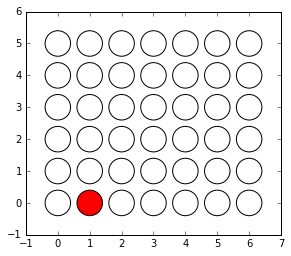

In [136]:
board = NewTable()
board = MakeMove(board, w, 1)
DrawBoard(board)

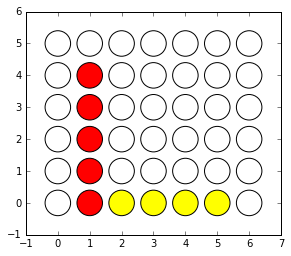

In [140]:
board, ok = DropIn(board, 5, 2)
board     = MakeMove(board, w, 1)
DrawBoard(board)

In [1557]:
pd.DataFrame(w1).to_hdf('Forza','Trained')

In [1596]:
w0 = pd.read_hdf('Forza','Trained').as_matrix()

# Old Stuffs

In [ ]:
def LinearChallenge(w1, j):
    board = NewTable()
    i = 0
    moves = []
    while ( not IsFull(board) ):
    
        j = j % COLS
            
        moves.append(Response(board, w1))
        board, ok = DropIn(board, moves[i], 1)
        if (not ok) :
            x = 2
            break
        x = Winner(board)
        if x == 1 : break
            
        board, ok = DropIn(board, j, 2)
        x = Winner(board)
        if x == 2 : break
            
        i += 1
        j += 1
    return [x,i,board, moves]

def ConstantChallenge(w1, j):
    board = NewTable()
    j = j % COLS
    i = 0
    moves = []
    while ( not IsFull(board) ):
            
        moves.append(Response(board, w1))
        board, ok = DropIn(board, moves[i], 1)
        if (not ok) :
            x = 2
            break
        x = Winner(board)
        if x == 1 : break
            
        board, ok = DropIn(board, j, 2)
        x = Winner(board)
        if x == 2 : break
            
        i += 1
    return [x,i,board, moves]

def Challenge(w1,w2):
    board = NewTable()
    i = 0
    moves = []
    while ( not IsFull(board) ):
        #print(i)
        #if i > 50 : return [x,i,board]
        moves.append(Response(board, w1))
        board, ok = DropIn(board, moves[i], 1)
        if (not ok) :
            x = 2
            break
        x = Winner(board)
        if x == 1 : break
        board, ok = DropIn(board, Response(board, w2), 2)
        if (not ok) :
            x = 0
            break
        x = Winner(board)
        if x == 2 : break
        
        i += 1
    return [x,i,board, moves]


def PickBest(w):
    fits = np.zeros(POPU)

    for p in range(0, POPU):
        w1 = w[p]
        fits[p] = FitnessOf(w1,w)

    best   = np.argmax(fits)
    w1 = w[best]
    best_f = fits[best].copy()
    fits[best] = 0
    best   = np.argmax(fits)
    w2 = w[best]
    return w1, w2, best_f


def FitnessOf(w1, w):
    fitness = 0
    sample  = np.random.randint(0, len(w), size=LIFE)
    
    for j in range(0, LIFE):
        w2 = RandomWeights()
        x, i, board, moves = Challenge(w1,w2)
        fitness += Reward(x,i)
            
    for j in range(0,LIFE):
        x, i, board, moves = ConstantChallenge(w1, j)
        fitness += Reward(x,i)
            
    for j in range(0,LIFE):
        x, i, board, moves = LinearChallenge(w1, j)
        fitness += Reward(x,i)
        
    for p in sample:
        w2 = w[p]
        x, i, board, moves = Challenge(w1,w2)
        fitness += Reward(x,i)

    return fitness

# Tensor Flow

In [147]:
import tensorflow as tf

In [324]:
%%time
#train = []

for i in range(0,10):
    board, moves, x = NewTable(), [], 0
    board, moves, x = RandomMatch(board, moves, x)
    if x > 1: train.append([board, moves].copy())
        
print(len(train))

10000
CPU times: user 486 ms, sys: 2.87 ms, total: 489 ms
Wall time: 534 ms


In [ ]:
X = np.array([ Input(board)         for (board, moves) in train ])
Y = np.array([ HotVector(moves[-1]) for (board, moves) in train ])

In [390]:
np.savetxt('Train_X.csv', X)
np.savetxt('Train_Y.csv', Y)

In [326]:
x = tf.placeholder(tf.float32, [None, INPUT])
W = tf.Variable(tf.zeros([INPUT, COLS]))
b = tf.Variable(tf.zeros([COLS]))

In [327]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

y_ = tf.placeholder(tf.float32, [None, COLS])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [328]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [342]:
%%time
N = 200
for i in range(1000):
    train_X, train_Y = RandomTrain(X,Y,N)
    sess.run(train_step, feed_dict={x: train_X, y_: train_Y})

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={x: X, y_: Y}))

w = W.eval(sess).T

0.639164
CPU times: user 3.87 s, sys: 140 ms, total: 4.01 s
Wall time: 3.5 s


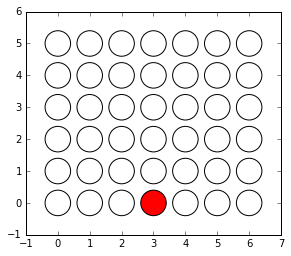

In [373]:
board = NewTable()
board = MakeMove(board, w, 1)
DrawBoard(board)

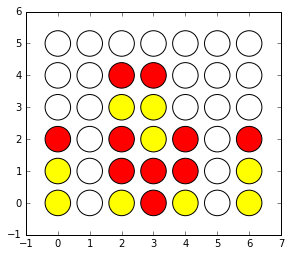

In [382]:
board, ok = DropIn(board, 2, 2)
board     = MakeMove(board, w, 1)
AnnounceWinner(board)
DrawBoard(board)

In [391]:
np.savetxt("Forza.csv", w)

In [392]:
X.shape

(10000, 85)